<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/classificationModelling_PubchemFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PubChem Feature Based Classification Modelling

## Introduction

PubChem Substructure Fingerprint is a binary substructure(molecular fragments) fingerprint(ordered list of binary bits) originally developed for PubChem’s similarity neighboring and similarity searching.
PubChem Substructure Fingerprint. Fingerprints of 881 bits were generated(PubChem Substructure Fingerprint, 2009).

## Data loading and Preprocessing



In [ ]:
import multiprocessing
print("Number of CPU cores:", multiprocessing.cpu_count())

In [ ]:
# For Reporducibility
import numpy as np
np.random.seed(42)

In [ ]:
# Tpot requires numpy==1.23.3 as of june 2024
!pip install numpy==1.23.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.3 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.3 which is incompatible.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading

Acquisition of the primary molecular dataset of the human acetylcholinesterase inhibitor was done from ChEMBL(ID:ChEMBL22). From 18,204 inhibitor entries, 4077 compounds with reported IC50 value and validated SMILE annotations were chosen, with redundant chemical structures resolved by randomly selecting one from the most frequently occurring activity label group. The resulting dataset comprises 2,330 instances labeled as positive and 1,747 instances labeled as negative. Molecules with an IC50 value less than 1uM were labeled as positives, and greater than 1 uM were labeled as negatives.

In [ ]:
# Load dataset
import pandas as pd
df2=pd.read_excel('/content/drive/MyDrive/StandarizedSmiles_cutOFF800daltonMolecularweight (1).xlsx')
df2.head(5)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,tSNE1,tSNE2,MolecularWeight,Frequency,cleanedMol
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,-52.761700,-42.736099,275.352,27,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,-63.027809,-53.765778,325.364,1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,-61.968063,-54.078575,263.293,1,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,57.758297,-8.911607,212.296,4,Cc1ccc2c(N)c3c(nc2c1)CCCC3
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,61.242554,5.783804,341.455,3,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2


In [ ]:
df = pd.concat([df2['cleanedMol'], df2['Molecule ChEMBL ID']], axis=1)
# Writing the concatenated DataFrame df to a tab-separated file named 'molecule.smi', without including index and header
df.to_csv('molecule.smi', sep='\t', index=False, header=False)
df


,cleanedMol,Molecule ChEMBL ID
0,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,CHEMBL94
1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,CHEMBL207777
2,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,CHEMBL205967
3,Cc1ccc2c(N)c3c(nc2c1)CCCC3,CHEMBL60119
4,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,CHEMBL294525
...,...,...
4072,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)n1c(O)ccc1O)...,CHEMBL4077157
4073,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2,CHEMBL3906317
4074,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12,CHEMBL4800328
4075,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1,CHEMBL4797670


### Descriptor generation and feature preparation
The method for descriptor generation is adopted from (https://colab.research.google.com/drive/1Kunjr8hF3MQPPN_AGedBP07AOE5Bcu1M?usp=sharing#scrollTo=1msUAjuKiIGP)


In [ ]:
!pip install padelpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 50.5 MB/s eta 0:00:00


In [ ]:
!wget https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
!unzip fingerprints_xml.zip

--2024-06-12 18:39:36--  https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip [following]
--2024-06-12 18:39:36--  https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10871 (11K) [application/zip]
Saving to: ‘fingerprints_xml.zip’

fingerprints_xml.zi 100%[===================>]  10.62K  --.-KB/s    in 0s      

2024-06-12 18:39:36 (66.8 MB/s) - ‘fingerprints_xml.zip’ saved [10871/10871]

Archive:  fingerprints_xm

In [ ]:
import glob
xml_files = glob.glob("*.xml")
xml_files.sort()
xml_files

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [ ]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [ ]:
fp = dict(zip(FP_list, xml_files))


In [ ]:
fp['PubChem']

'PubchemFingerprinter.xml'

In [ ]:
fp

{'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml',
 'Substructure': 'SubstructureFingerprinter.xml'}

In [ ]:
fp['PubChem']

'PubchemFingerprinter.xml'

In [ ]:

# Importing the padeldescriptor module from padelpy library
from padelpy import padeldescriptor

# Specifying the fingerprint type
fingerprint = 'PubChem'

# Generating the output file name based on the fingerprint type
fingerprint_output_file = ''.join([fingerprint, '.csv'])  # Example: 'PubChem.csv'

# Extracting the descriptor types corresponding to the selected fingerprint from the DataFrame 'fp'
fingerprint_descriptortypes = fp[fingerprint]

# Generating molecular descriptors using padeldescriptor
padeldescriptor(mol_dir='molecule.smi',
                d_file=fingerprint_output_file,  # Output file name
                descriptortypes=fingerprint_descriptortypes,  # Descriptor types for the selected fingerprint
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=8,
                removesalt=True,
                log=True,
                fingerprints=True)


In [ ]:
descriptors = pd.read_csv(fingerprint_output_file)
descriptors

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL94,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL207777,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL205967,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL60119,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL294525,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4073,CHEMBL3906317,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4074,CHEMBL4800328,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4075,CHEMBL4797670,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = pd.concat([df2, descriptors.loc[:, 'PubchemFP0':]], axis=1)
df

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,0,0,0,0,0,0,0,0,0,0
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,0,0,0,0,0,0,0,0,0,0
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,0,0,0,0,0,0,0,0,0,0
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Installing RDKit from PyPI
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 24.8 MB/s eta 0:00:00


In [ ]:
# Drop any feature containing null values
df.dropna(axis=1)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,0,0,0,0,0,0,0,0,0,0
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,0,0,0,0,0,0,0,0,0,0
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,0,0,0,0,0,0,0,0,0,0
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
feature1=df.loc[:, 'PubchemFP0':]

In [ ]:
feature1

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4073,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4074,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4075,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
target=df['classLabel']
target.head()

0    1
1    1
2    0
3    1
4    1
Name: classLabel, dtype: int64

## AutoML Modeling

AutoML (specifically TPOT) is an automated optimization method based on trees for enhancing feature processing and machine learning models, with the goal of maximizing classification accuracy through genetic algorithms. It serves as an interface for scikit-learn, wherein each operator in the learning pipeline aligns with a machine learning algorithm or standard feature scaler. Its key components include supervised classification operators, feature processing operators, feature selection operators, and an operator for consolidating modified dataset variants into one (Olson & Moore, 2019). Construction of learning pipelines includes incorporation of operators as genetic programming primitives for creation of genetic programming trees, and a genetic algorithm, implemented in the DEAP python package,  automatically generates and optimizes tree-based pipelines(Fortin, n.d.; Olson et al., 2016; Olson & Moore, 2019)

In [ ]:
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=f408974b81884ee53a40b8e309b565421c34c9da11ac1bc7838a2e3a8715877d
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
# Import necessary libraries
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
# feature names
feature_names = feature1.columns.tolist()
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(feature1, target, test_size=0.20, stratify=target, random_state=42)
# Create an instance of TPOTClassifier with five fold cross validation
tpot = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=42, verbosity=2)
# Fit TPOT to the training data
tpot.fit(X_train, y_train)
# Get the best pipeline from TPOT
best_pipeline = tpot.fitted_pipeline_


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8494334783303111

Generation 2 - Current best internal CV score: 0.856180065577467

Generation 3 - Current best internal CV score: 0.856180065577467

Generation 4 - Current best internal CV score: 0.856180065577467

Generation 5 - Current best internal CV score: 0.856180065577467

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=2, min_samples_split=16, n_estimators=100)


In [ ]:
joblib.dump(best_pipeline, 'best_pipeline_tpot_rdkit.pkl')

['best_pipeline_tpot_rdkit.pkl']

### Evaluation of AutoML Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, cohen_kappa_score,
                             matthews_corrcoef, accuracy_score)
from sklearn.model_selection import cross_val_score
import joblib
# Make predictions on the test data
y_test_pred = best_pipeline.predict(X_test)
# Calculate evaluation metrics
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_test_pred)
cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Calculate cross-validation scores, std, and 95% CI
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5)
cv_mean_score = np.mean(cv_scores)
cv_std = np.std(cv_scores)
cv_ci = 1.96 * cv_std  # 95% confidence interval

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Store the evaluation results
evaluation_results = {
    'Model': ['TPOT Best Pipeline'],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC-AUC': [roc_auc],
    'Cohen\'s Kappa': [cohen_kappa],
    'MCC': [mcc],
    'CV Mean Score': [cv_mean_score],
    'CV Std Dev': [cv_std],
    'CV 95% CI': [cv_ci],
    'Test Accuracy': [test_accuracy],
}

# Convert the evaluation results to a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Save the evaluation results to an Excel file
evaluation_df.to_excel('tpot_best_pipeline_evaluation.xlsx', index=False)
print("Evaluation results of TPOT best pipeline saved to 'tpot_best_pipeline_evaluation.xlsx'.")

# Save the best model parameters to a DataFrame
best_model_parameters = pd.DataFrame([best_pipeline.get_params()])

# Combine the evaluation results, best model parameters, and feature names into a single DataFrame
results_df = pd.concat([evaluation_df, best_model_parameters], axis=1)

# Save the combined information to an Excel file
results_df.to_excel('tpot_best_pipeline_results.xlsx', index=False)
print("Evaluation results, best model parameters, and feature names saved to 'tpot_best_pipeline_results.xlsx'.")

# Print Evaluation Results
print("\nEvaluation Results:")
print(evaluation_df)

# Print Best Model Parameters
print("\nBest Model Parameters:")
print(best_model_parameters)


Evaluation results of TPOT best pipeline saved to 'tpot_best_pipeline_evaluation.xlsx'.
Evaluation results, best model parameters, and feature names saved to 'tpot_best_pipeline_results.xlsx'.

Evaluation Results:
                Model  Precision    Recall  F1 Score   ROC-AUC  Cohen's Kappa  \
0  TPOT Best Pipeline   0.846542  0.846814  0.846207  0.840276       0.685181   

        MCC  CV Mean Score  CV Std Dev  CV 95% CI  Test Accuracy  
0  0.685967        0.85618    0.012426   0.024354       0.846814  

Best Model Parameters:
  memory                                              steps  verbose  \
0   None  [(randomforestclassifier, (DecisionTreeClassif...    False   

                              randomforestclassifier  \
0  (DecisionTreeClassifier(criterion='entropy', m...   

   randomforestclassifier__bootstrap  randomforestclassifier__ccp_alpha  \
0                              False                                0.0   

  randomforestclassifier__class_weight randomforestclass

## Aggregrate modeling with hyperparameter optimization and evaluation
The aggregate method involves systematically exploring a diverse array of classical and ensemble machine learning algorithms, coupled with consistent and rigorous hyperparameter optimization, employing five-fold cross-validation, and primarily assessing performance based on the AUC ROC  score. All models are built from sklearn libraries(Supervised Learning, 2024).  Classical model that were used were Decision Tree, Support vector machine, Logistic regression, Mult-layer perceptron, Gradient Boosting, and K-Nearest Neighbors, and ensemble models include random forest, Gradient Boosting, Bagging, AdaBoost, Extra Trees, HistGradientBoosting and Stacking classifier. The ensemble technique merges predictions from multiple models to generate a consensus prediction, with the assumption that errors of one model will be compensated by other models and vice versa(Sagi & Rokach, 2018).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score,
    matthews_corrcoef,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    StackingClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import joblib

# Store feature names
feature_names = feature1.columns.tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature1, target, test_size=0.2, random_state=42)

# Use StandardScaler to scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a dictionary of models to loop through
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(solver='sag'),
    'SVM': SVC(probability=True),
    'MLP': MLPClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Stacking': StackingClassifier(estimators=[('rf', RandomForestClassifier()), ('gb', GradientBoostingClassifier())], final_estimator=LogisticRegression()),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100),
    'HistGradientBoosting': HistGradientBoostingClassifier(max_iter=100)
}

# Define hyperparameters for Grid Search
param_grid = {
    'Random Forest': {'n_estimators': [100, 200, 300]},
    'Logistic Regression': {'C': [0.1, 1]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (50, 50)]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
    'Decision Tree': {'max_depth': [None, 10, 20]},
    'Naive Bayes': {},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1.0]},
    'Bagging': {},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Stacking': {},
    'Extra Trees': {'n_estimators': [100, 200, 300]},
    'HistGradientBoosting': {'max_iter': [100, 200, 300]}
}

# Initialize variables to track the best model and its evaluation metrics
best_models_results = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC-AUC': [],
    'Cohen\'s Kappa': [],
    'MCC': [],
    'Best Parameters': [],
    'CV Mean Score': [],
    'CV Std Dev': [],
    'CV 95% CI': [],
    'Features': []
}

# Initialize variables for the best single model
best_single_model = None
best_single_model_name = None
best_single_model_roc_auc = 0.0
best_single_model_precision = 0.0
best_single_model_recall = 0.0
best_single_model_f1_score = 0.0
best_single_model_cohen_kappa = 0.0
best_single_model_mcc = 0.0
best_single_model_parameters = None
best_single_model_cv_mean_score = 0.0
best_single_model_cv_std_dev = 0.0
best_single_model_cv_ci = 0.0
best_single_model_features = None

# Loop through each model, perform Grid Search, calculate metrics, and create visualizations
for model_name, model in models.items():
    if model_name in param_grid:
        # Perform Grid Search for hyperparameter optimization
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='roc_auc')
        grid_search.fit(X_train_scaled, y_train)
        current_best_model = grid_search.best_estimator_
        current_best_hyperparameters = grid_search.best_params_
    else:
        current_best_model = model

    # Calculate cross-validation score
    cv_scores = cross_val_score(current_best_model, X_train_scaled, y_train, cv=5)
    cv_mean_score = cv_scores.mean()
    cv_std_dev = cv_scores.std()
    cv_ci = 1.96 * cv_std_dev  # 95% confidence interval

    # Train the current best model on the full training data
    current_best_model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    y_test_pred = current_best_model.predict(X_test_scaled)

    # Calculate evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_test_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Print evaluation results for each model
    print("\nModel:", model_name)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC-AUC:", roc_auc)
    print("Cohen's Kappa:", cohen_kappa)
    print("MCC:", mcc)
    print("Best Parameters:", current_best_hyperparameters)
    print("CV Mean Score:", cv_mean_score)
    print("CV Std Dev:", cv_std_dev)
    print("CV 95% CI:", cv_ci)
    print("Features:", feature_names)

    # Store the results of the best model for each classifier
    best_models_results['Model'].append(model_name)
    best_models_results['Precision'].append(precision)
    best_models_results['Recall'].append(recall)
    best_models_results['F1 Score'].append(f1)
    best_models_results['ROC-AUC'].append(roc_auc)
    best_models_results['Cohen\'s Kappa'].append(cohen_kappa)
    best_models_results['MCC'].append(mcc)
    best_models_results['Best Parameters'].append(current_best_hyperparameters)
    best_models_results['CV Mean Score'].append(cv_mean_score)
    best_models_results['CV Std Dev'].append(cv_std_dev)
    best_models_results['CV 95% CI'].append(cv_ci)
    best_models_results['Features'].append(feature_names)

    # Update the best single model if the current model has a higher ROC-AUC score
    if roc_auc > best_single_model_roc_auc:
        best_single_model_roc_auc = roc_auc
        best_single_model_name = model_name
        best_single_model_precision = precision
        best_single_model_recall = recall
        best_single_model_f1_score = f1
        best_single_model_cohen_kappa = cohen_kappa
        best_single_model_mcc = mcc
        best_single_model_parameters = current_best_hyperparameters
        best_single_model_cv_mean_score = cv_mean_score
        best_single_model_cv_std_dev = cv_std_dev
        best_single_model_cv_ci = cv_ci
        best_single_model_features = feature_names
        best_single_model = current_best_model

# Convert the dictionary to a DataFrame
best_models_df = pd.DataFrame(best_models_results)

# Print the results
print("\nBest Models Results:")
print(best_models_df)

# Save the DataFrame to an Excel file
best_models_df.to_excel('best_models_results.xlsx', index=False)
print("Best models results saved to 'best_models_results.xlsx'.")

# Save the results of the best single model to a separate Excel file
best_single_model_results = {
    'Model': [best_single_model_name],
    'Precision': [best_single_model_precision],
    'Recall': [best_single_model_recall],
    'F1 Score': [best_single_model_f1_score],
    'ROC-AUC': [best_single_model_roc_auc],
    'Cohen\'s Kappa': [best_single_model_cohen_kappa],
    'MCC': [best_single_model_mcc],
    'Best Parameters': [best_single_model_parameters],
    'CV Mean Score': [best_single_model_cv_mean_score],
    'CV Std Dev': [best_single_model_cv_std_dev],
    'CV 95% CI': [best_single_model_cv_ci],
    'Features': [best_single_model_features]
}

best_single_model_df = pd.DataFrame(best_single_model_results)

# Print the results of the best single model
print("\nBest Single Model Results:")
print(best_single_model_df)

# Save the DataFrame to an Excel file
best_single_model_df.to_excel('best_single_model_results.xlsx', index=False)
print("\nBest single model results saved to 'best_single_model_results_optimized.xlsx'.")

# Save the trained model of the best single model to a file
joblib.dump(best_single_model, 'best_single_model.pkl')
print("\nTrained model of the best single model saved to 'best_single_model.pkl'.")



Model: Random Forest
Precision: 0.8531843143009643
Recall: 0.8529411764705882
F1 Score: 0.8530420200995759
ROC-AUC: 0.8506192519926425
Cohen's Kappa: 0.7002424509587833
MCC: 0.7002774091303631
Best Parameters: {'n_estimators': 100}
CV Mean Score: 0.8411569067728933
CV Std Dev: 0.019037468973612484
CV 95% CI: 0.03731343918828047
Features: ['PubchemFP0', 'PubchemFP1', 'PubchemFP2', 'PubchemFP3', 'PubchemFP4', 'PubchemFP5', 'PubchemFP6', 'PubchemFP7', 'PubchemFP8', 'PubchemFP9', 'PubchemFP10', 'PubchemFP11', 'PubchemFP12', 'PubchemFP13', 'PubchemFP14', 'PubchemFP15', 'PubchemFP16', 'PubchemFP17', 'PubchemFP18', 'PubchemFP19', 'PubchemFP20', 'PubchemFP21', 'PubchemFP22', 'PubchemFP23', 'PubchemFP24', 'PubchemFP25', 'PubchemFP26', 'PubchemFP27', 'PubchemFP28', 'PubchemFP29', 'PubchemFP30', 'PubchemFP31', 'PubchemFP32', 'PubchemFP33', 'PubchemFP34', 'PubchemFP35', 'PubchemFP36', 'PubchemFP37', 'PubchemFP38', 'PubchemFP39', 'PubchemFP40', 'PubchemFP41', 'PubchemFP42', 'PubchemFP43', 'Pubchem

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 


Model: Logistic Regression
Precision: 0.8167160619637117
Recall: 0.8125
F1 Score: 0.813279344792683
ROC-AUC: 0.8145003065603924
Cohen's Kappa: 0.6217048250451477
MCC: 0.6237846940034846
Best Parameters: {'C': 0.1}
CV Mean Score: 0.7936184105450069
CV Std Dev: 0.010710270650489176
CV 95% CI: 0.020992130474958785
Features: ['PubchemFP0', 'PubchemFP1', 'PubchemFP2', 'PubchemFP3', 'PubchemFP4', 'PubchemFP5', 'PubchemFP6', 'PubchemFP7', 'PubchemFP8', 'PubchemFP9', 'PubchemFP10', 'PubchemFP11', 'PubchemFP12', 'PubchemFP13', 'PubchemFP14', 'PubchemFP15', 'PubchemFP16', 'PubchemFP17', 'PubchemFP18', 'PubchemFP19', 'PubchemFP20', 'PubchemFP21', 'PubchemFP22', 'PubchemFP23', 'PubchemFP24', 'PubchemFP25', 'PubchemFP26', 'PubchemFP27', 'PubchemFP28', 'PubchemFP29', 'PubchemFP30', 'PubchemFP31', 'PubchemFP32', 'PubchemFP33', 'PubchemFP34', 'PubchemFP35', 'PubchemFP36', 'PubchemFP37', 'PubchemFP38', 'PubchemFP39', 'PubchemFP40', 'PubchemFP41', 'PubchemFP42', 'PubchemFP43', 'PubchemFP44', 'PubchemFP

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


Model: AdaBoost
Precision: 0.8082007939045184
Recall: 0.8063725490196079
F1 Score: 0.8068930180216518
ROC-AUC: 0.8055793991416309
Cohen's Kappa: 0.6072716639048641
MCC: 0.6078803886430365
Best Parameters: {'n_estimators': 200}
CV Mean Score: 0.7755291763357416
CV Std Dev: 0.002987484678699488
CV 95% CI: 0.005855469970250996
Features: ['PubchemFP0', 'PubchemFP1', 'PubchemFP2', 'PubchemFP3', 'PubchemFP4', 'PubchemFP5', 'PubchemFP6', 'PubchemFP7', 'PubchemFP8', 'PubchemFP9', 'PubchemFP10', 'PubchemFP11', 'PubchemFP12', 'PubchemFP13', 'PubchemFP14', 'PubchemFP15', 'PubchemFP16', 'PubchemFP17', 'PubchemFP18', 'PubchemFP19', 'PubchemFP20', 'PubchemFP21', 'PubchemFP22', 'PubchemFP23', 'PubchemFP24', 'PubchemFP25', 'PubchemFP26', 'PubchemFP27', 'PubchemFP28', 'PubchemFP29', 'PubchemFP30', 'PubchemFP31', 'PubchemFP32', 'PubchemFP33', 'PubchemFP34', 'PubchemFP35', 'PubchemFP36', 'PubchemFP37', 'PubchemFP38', 'PubchemFP39', 'PubchemFP40', 'PubchemFP41', 'PubchemFP42', 'PubchemFP43', 'PubchemFP44

## Cross species evaluation

### Upload and prep for species dataset

Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.

In [ ]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/CleanedTestDatasetSmiles/df_humanIndependent.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/CleanedTestDatasetSmiles/df_mosquito.xlsx')

In [ ]:
df_humanIndependent

,CdId,Structure,Mol Weight,Formula,index,PMID,Chemical Name,Smiles,Standard Value,Standard Units,Standard Relation,Unnamed: 6,Unnamed: 7,InChi,MW,standardized_Standard Units,neg_log_M_Standard Valuemean,binary_activities,cleanedMol
0,1,NaN,400.950,C23H29ClN2O2,0,PMID31316368,1-(4-Amino-5-chloro-2-methoxyphenyl)-3-(1-(3-m...,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,161,nM,'=',NaN,NaN,MLGZODWUOIZOPO-UHFFFAOYSA-N,400.191756,nm,7.132772,1,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1
1,2,NaN,582.793,C35H46N6O2,1,PMID32932702,13-bis[5-(o-cyanobenzylethylamino)pentyl]-6-me...,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,7.3,nM,'=',NaN,NaN,HSTIQTQFKBPUBM-UHFFFAOYSA-N,582.368225,nm,8.453114,1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...
2,3,NaN,610.847,C37H50N6O2,2,PMID32932702,13-bis[6-(o-cyanobenzylethylamino)hexyl]-6-met...,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,29,nM,'=',NaN,NaN,VZLMPEWEWNBPNU-UHFFFAOYSA-N,610.399525,nm,7.578695,1,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...
3,4,NaN,618.826,C38H46N6O2,3,PMID32932702,13-bis[5-(o-cyanobenzylethylamino)pentyl]-quin...,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,38,nM,'=',NaN,NaN,MUHGJDAKOZGKRH-UHFFFAOYSA-N,618.368225,nm,7.378729,1,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...
4,5,NaN,213.303,C14H17N2,4,PMID29534488,9-Amino-1234-tetrahydro-10-methylacridin-10-iu...,C[n+]1c2c(c(N)c3ccccc31)CCCC2,12,µM,'=',NaN,NaN,XZCXCNCLCXZILU-UHFFFAOYSA-O,213.138625,um,4.920819,0,C[n+]1c2c(c(N)c3ccccc31)CCCC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,204,NaN,427.504,C26H25N3O3,211,PMID31852270,N-(4-((Benzyl(methyl)amino)methyl)phenyl)-7-me...,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,2.3,µM,'=',NaN,NaN,RISZPUMPOOHFSR-UHFFFAOYSA-N,427.189592,um,5.638272,0,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...
204,205,NaN,457.530,C27H27N3O4,212,PMID31852270,N-(4-((benzyl(methyl)amino)methyl)phenyl)-67-d...,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,4.5,µM,'=',NaN,NaN,PHAZELHZUUHUTB-UHFFFAOYSA-N,457.200156,um,5.346787,0,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...
205,206,NaN,554.739,C33H42N6O2,213,PMID32932702,13-bis[4-(o-cyanobenzylethylamino)butyl]-6-met...,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,7,nM,'=',fixed,NaN,HWHRMPMHFDVNAP-UHFFFAOYSA-N,554.336925,nm,8.154902,1,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...
206,207,NaN,526.685,C31H38N6O2,214,PMID32932702,13-bis[5-(o-cyanobenzylamino)pentyl]-6-methylu...,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,480,nM,'=',NaN,NaN,LCCSXIJDKYAOER-UHFFFAOYSA-N,526.305624,nm,6.318759,1,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...


In [ ]:
df_humanIndependent=df_humanIndependent[['Smiles',	'binary_activities',	'cleanedMol']]

In [ ]:
df_humanIndependent.rename(columns={'binary_activities': 'single-class-label'}, inplace=True)

<ipython-input-66-e096e6f94345>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_humanIndependent.rename(columns={'binary_activities': 'single-class-label'}, inplace=True)


### Descriptor generation human independent dataset

In [ ]:
#Conactnating necessary columns
df_humanIndependent.to_csv('molecule_humanIndependent.smi', sep='\t', index=False, header=False)
df_humanIndependent

,Smiles,single-class-label,cleanedMol
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0,C[n+]1c2c(c(N)c3ccccc31)CCCC2
...,...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...


In [ ]:
#Setting the fingerprint module

from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file_HumanIndependent = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule_humanIndependent.smi',
                d_file=fingerprint_output_file_HumanIndependent, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml',
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=8,
                removesalt=True,
                log=True,
                fingerprints=True)

In [ ]:
descriptors_humanIndependent = pd.read_csv(fingerprint_output_file_HumanIndependent)
descriptors_humanIndependent

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1\tCOc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1\tCCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1\tCCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1\tCCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2cccc...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0\tC[n+]1c2c(c(N)c3ccccc31)CCCC2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0\tCOc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204,0\tCOc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,1\tCCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,1\tCc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCN...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### mosquito

In [ ]:
#Conactnating necessary columns
df_mosquito.to_csv('molecule_mosquito.smi', sep='\t', index=False, header=False)
df_mosquito

,SMILES,single-class-label,cleanedMol
0,COc1ccccc1NC(=S)NCCN(C)C,0,COc1ccccc1NC(=S)NCCN(C)C
1,COc1ccc(NC(=S)NCCN2CCOCC2)cc1Cl,1,COc1ccc(NC(=S)NCCN2CCOCC2)cc1Cl
2,CCN1CCN(C2CCN(C(=O)COc3ccc(-c4ccccc4)cc3)CC2)CC1,1,CCN1CCN(C2CCN(C(=O)COc3ccc(-c4ccccc4)cc3)CC2)CC1
3,CCC(CC)n1cc(C(=O)C(F)F)cn1,1,CCC(CC)n1cc(C(=O)C(F)F)cn1
4,CC(C)n1cc(C(=O)C(F)F)cn1,1,CC(C)n1cc(C(=O)C(F)F)cn1
...,...,...,...
67,COc1ccccc1N=C(S)NCCN1CCOCC1,0,COc1ccccc1NC(=S)NCCN1CCOCC1
68,COc1cc(NC(=S)NCCN2CCOCC2)ccc1Cl,0,COc1cc(NC(=S)NCCN2CCOCC2)ccc1Cl
69,CC1CCN(CCNC(=S)Nc2cccc(Cl)c2)CC1,0,CC1CCN(CCNC(=S)Nc2cccc(Cl)c2)CC1
70,COc1ccc(NC(=S)NCCN(C)C)cc1,0,COc1ccc(NC(=S)NCCN(C)C)cc1


In [ ]:
#Setting the fingerprint module

from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file_mosquito = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule_mosquito.smi',
                d_file=fingerprint_output_file_mosquito, #'Substructure.csv'
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=8,
                removesalt=True,
                log=True,
                fingerprints=True)

In [ ]:
descriptors_mosquito = pd.read_csv(fingerprint_output_file_mosquito)
descriptors_mosquito

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0\tCOc1ccccc1NC(=S)NCCN(C)C,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1\tCOc1ccc(NC(=S)NCCN2CCOCC2)cc1Cl,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1\tCCN1CCN(C2CCN(C(=O)COc3ccc(-c4ccccc4)cc3)CC...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1\tCCC(CC)n1cc(C(=O)C(F)F)cn1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1\tCC(C)n1cc(C(=O)C(F)F)cn1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0\tCOc1ccccc1NC(=S)NCCN1CCOCC1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68,0\tCOc1cc(NC(=S)NCCN2CCOCC2)ccc1Cl,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0\tCC1CCN(CCNC(=S)Nc2cccc(Cl)c2)CC1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0\tCOc1ccc(NC(=S)NCCN(C)C)cc1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Eel

In [ ]:
#Conactnating necessary columns
df_eel.to_csv('molecule_eel.smi', sep='\t', index=False, header=False)
df_eel

,SMILES,single-class-label,cleanedMol
0,c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc...,1,c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc...
1,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,1,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
2,Cc1cccc(Nc2ccccc2C(=O)NCCCCCC(=O)NCCCCNc2c3c(n...,1,Cc1cccc(Nc2ccccc2C(=O)NCCCCCC(=O)NCCCCNc2c3c(n...
3,O=C1Nc2ccccc2/C1=C\c1cc[n+](Cc2ccccc2Cl)cc1,1,O=C1Nc2ccccc2/C1=C\c1cc[n+](Cc2ccccc2Cl)cc1
4,COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2,0,COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2
...,...,...,...
5454,O=[N+]([O-])c1ccc2nc(-c3ccccc3)cc(-c3ccccc3)c2c1,0,O=[N+]([O-])c1ccc2nc(-c3ccccc3)cc(-c3ccccc3)c2c1
5455,Clc1ccc2nc(-c3c[nH]c4ccccc34)cc(-c3ccccc3)c2c1,0,Clc1ccc2nc(-c3c[nH]c4ccccc34)cc(-c3ccccc3)c2c1
5456,COc1ccc(-c2cc(-c3ccccc3)c3cc([N+](=O)[O-])ccc3...,0,COc1ccc(-c2cc(-c3ccccc3)c3cc([N+](=O)[O-])ccc3...
5457,C#CCN(C)[C@@H](C)Cc1ccccc1,0,C#CCN(C)[C@@H](C)Cc1ccccc1


In [ ]:
#Setting the fingerprint module

from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file_cow = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule_eel.smi',
                d_file=fingerprint_output_file_cow, #'Substructure.csv'
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=8,
                removesalt=True,
                log=True,
                fingerprints=True)

In [ ]:
descriptors_eel = pd.read_csv(fingerprint_output_file_cow)
descriptors_eel

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1\tc1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1\tCNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1\tCc1cccc(Nc2ccccc2C(=O)NCCCCCC(=O)NCCCCNc2c3...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1\tO=C1Nc2ccccc2/C1=C\c1cc[n+](Cc2ccccc2Cl)cc1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0\tCOc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,0\tO=[N+]([O-])c1ccc2nc(-c3ccccc3)cc(-c3ccccc3...,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5455,0\tClc1ccc2nc(-c3c[nH]c4ccccc34)cc(-c3ccccc3)c2c1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5456,0\tCOc1ccc(-c2cc(-c3ccccc3)c3cc([N+](=O)[O-])c...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5457,0\tC#CCN(C)[C@@H](C)Cc1ccccc1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###Cow

In [ ]:
#Conactnating necessary columns
df_cow.to_csv('molecule_cow.smi', sep='\t', index=False, header=False)
df_cow

,SMILES,single-class-label,cleanedMol
0,CC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3C(C1)C2,1,CC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3C(C1)C2
1,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,1,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2
2,O=C(CCCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2)NCCc1c[n...,1,O=C(CCCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2)NCCc1c[n...
3,CC1=C[C@@H]2Cc3nc4cc(Cl)ccc4c(NCCCN(C)CCCCNc4c...,1,CC1=C[C@@H]2Cc3nc4cc(Cl)ccc4c(NCCCN(C)CCCCNc4c...
4,CC1=CC2Cc3nc4cc(Cl)ccc4c(NCCCCCCNc4c5c(nc6cccc...,1,CC1=CC2Cc3nc4cc(Cl)ccc4c(NCCCCCCNc4c5c(nc6cccc...
...,...,...,...
452,CC1(C)CC(OS(C)(=O)=O)=NN1S(C)(=O)=O,0,CC1(C)CC(OS(C)(=O)=O)=NN1S(C)(=O)=O
453,COP(=O)(OC)C(O)C(Cl)(Cl)Cl,0,COP(=O)(OC)C(O)C(Cl)(Cl)Cl
454,CC1(C)CC(OS(C)(=O)=O)=NN1C(=O)Nc1ccccc1,0,CC1(C)CC(OS(C)(=O)=O)=NN1C(=O)Nc1ccccc1
455,CC(C)C(=O)N1N=C(OS(C)(=O)=O)CC1(C)C,0,CC(C)C(=O)N1N=C(OS(C)(=O)=O)CC1(C)C


In [ ]:
#Setting the fingerprint module

from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file_cow = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule_cow.smi',
                d_file=fingerprint_output_file, #'Substructure.csv'
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=8,
                removesalt=True,
                log=True,
                fingerprints=True)

In [ ]:
descriptors_cow = pd.read_csv(fingerprint_output_file_cow)
descriptors_cow

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1\tCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3C(C1)C2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1\tCCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1\tO=C(CCCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2)NCCc1...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1\tCC1=C[C@@H]2Cc3nc4cc(Cl)ccc4c(NCCCN(C)CCCCN...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1\tCC1=CC2Cc3nc4cc(Cl)ccc4c(NCCCCCCNc4c5c(nc6c...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0\tCC1(C)CC(OS(C)(=O)=O)=NN1S(C)(=O)=O,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
453,0\tCOP(=O)(OC)C(O)C(Cl)(Cl)Cl,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
454,0\tCC1(C)CC(OS(C)(=O)=O)=NN1C(=O)Nc1ccccc1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
455,0\tCC(C)C(=O)N1N=C(OS(C)(=O)=O)CC1(C)C,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###Ray

In [ ]:
#Conactnating necessary columns
df_ray.to_csv('molecule_ray.smi', sep='\t', index=False, header=False)
df_ray

,SMILES,single-class-label,cleanedMol
0,CNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)c4cccnc4oc3...,1,CNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)c4cccnc4oc3...
1,c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc...,1,c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc...
2,CNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)c4ccccc4oc3...,1,CNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)c4ccccc4oc3...
3,CCN(CCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1cccc(OC(=O...,1,CCN(CCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1cccc(OC(=O...
4,CNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)cc(-c4ccccc...,1,CNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)cc(-c4ccccc...
...,...,...,...
1401,O=c1cc(-c2ccc(O)cc2)oc2cc(O)c(O)c(O)c12,0,O=c1cc(-c2ccc(O)cc2)oc2cc(O)c(O)c(O)c12
1402,CN(C)Cc1ccc(O)nc1,0,CN(C)Cc1ccc(=O)[nH]c1
1403,NCc1ccc(O)nc1,0,NCc1ccc(=O)[nH]c1
1404,c1ccc(-c2ccc(NCCN3CCOCC3)nn2)cc1,0,c1ccc(-c2ccc(NCCN3CCOCC3)nn2)cc1


In [ ]:
#Setting the fingerprint module

from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file_ray = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule_ray.smi',
                d_file=fingerprint_output_file_ray, #'Substructure.csv'
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=8,
                removesalt=True,
                log=True,
                fingerprints=True)

In [ ]:
descriptors_ray = pd.read_csv(fingerprint_output_file_ray)
descriptors_ray

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1\tCNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)c4cccnc4...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1\tc1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1\tCNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)c4ccccc4...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1\tCCN(CCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1cccc(OC...,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1\tCNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)cc(-c4cc...,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,0\tO=c1cc(-c2ccc(O)cc2)oc2cc(O)c(O)c(O)c12,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1402,0\tCN(C)Cc1ccc(=O)[nH]c1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1403,0\tNCc1ccc(=O)[nH]c1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1404,0\tc1ccc(-c2ccc(NCCN3CCOCC3)nn2)cc1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###Mouse

In [ ]:
#Conactnating necessary columns
df_mouse.to_csv('molecule_mouse.smi', sep='\t', index=False, header=False)
df_mouse

,SMILES,single-class-label,cleanedMol
0,CN(CCC1CCN(Cc2ccccc2)CC1)C(=O)c1ccccc1,1,CN(CCC1CCN(Cc2ccccc2)CC1)C(=O)c1ccccc1
1,Nc1c2c(nc3ccccc13)CCCC2,1,Nc1c2c(nc3ccccc13)CCCC2
2,O=C(NCCC1CCN(Cc2ccccc2)CC1)c1ccccc1,1,O=C(NCCC1CCN(Cc2ccccc2)CC1)c1ccccc1
3,O=C1c2ccccc2CN1CCC1CCN(Cc2ccccc2)CC1,1,O=C1c2ccccc2CN1CCC1CCN(Cc2ccccc2)CC1
4,CN(CCC1CCN(Cc2ccccc2)CC1)C(=O)c1ccc(S(=O)(=O)C...,1,CN(CCC1CCN(Cc2ccccc2)CC1)C(=O)c1ccc(S(=O)(=O)C...
...,...,...,...
363,CC[C@H](O)c1oc(=O)cc(OC)c1C,0,CC[C@H](O)c1oc(=O)cc(OC)c1C
364,CCCC1=C/C(=C\[C@H](O)[C@@H](C)O)OC1=O,0,CCCC1=C/C(=C\[C@H](O)[C@@H](C)O)OC1=O
365,CCN(CC)CCNS(=O)(=O)c1ccc(-c2ccc(Cl)cc2)cc1,0,CCN(CC)CCNS(=O)(=O)c1ccc(-c2ccc(Cl)cc2)cc1
366,CCN(CC)CCNS(=O)(=O)c1ccc2ccccc2c1,0,CCN(CC)CCNS(=O)(=O)c1ccc2ccccc2c1


In [ ]:
#Setting the fingerprint module

from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file_mouse = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule_mouse.smi',
                d_file=fingerprint_output_file_mouse, #'Substructure.csv'
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=8,
                removesalt=True,
                log=True,
                fingerprints=True)

In [ ]:
descriptors_mouse = pd.read_csv(fingerprint_output_file_mouse)
descriptors_mouse

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1\tCN(CCC1CCN(Cc2ccccc2)CC1)C(=O)c1ccccc1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1\tNc1c2c(nc3ccccc13)CCCC2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1\tO=C(NCCC1CCN(Cc2ccccc2)CC1)c1ccccc1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1\tO=C1c2ccccc2CN1CCC1CCN(Cc2ccccc2)CC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1\tCN(CCC1CCN(Cc2ccccc2)CC1)C(=O)c1ccc(S(=O)(=...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,0\tCC[C@H](O)c1oc(=O)cc(OC)c1C,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364,0\tCCCC1=C/C(=C\[C@H](O)[C@@H](C)O)OC1=O,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
365,0\tCCN(CC)CCNS(=O)(=O)c1ccc(-c2ccc(Cl)cc2)cc1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366,0\tCCN(CC)CCNS(=O)(=O)c1ccc2ccccc2c1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_humanIndependent=df_humanIndependent.merge(descriptors_humanIndependent, left_index=True, right_index=True)
df_cow=df_cow.merge(descriptors_cow, left_index=True, right_index=True)
df_eel=df_eel.merge(descriptors_eel, left_index=True, right_index=True)
df_mosquito=df_mosquito.merge(descriptors_mosquito, left_index=True, right_index=True)
df_mouse=df_mouse.merge(descriptors_mouse, left_index=True, right_index=True)
df_ray=df_ray.merge(descriptors_ray, left_index=True, right_index=True)

In [ ]:
df_humanIndependent

,Smiles,single-class-label,cleanedMol,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1\tCOc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1\tCCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C...,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1\tCCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc...,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1\tCCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2cccc...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0\tC[n+]1c2c(c(N)c3ccccc31)CCCC2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0\tCOc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0\tCOc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1\tCCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N...,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1\tCc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCN...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Test dataset preparation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature1, target, test_size=0.20, random_state=42)


In [ ]:
X_test

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
1749,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2053,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
538,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
438,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2685,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3937,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
221,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2031,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,0,0,0,0,0,0,0,0,0,0
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,0,0,0,0,0,0,0,0,0,0
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,0,0,0,0,0,0,0,0,0,0
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df_= pd.merge(df[['cleanedMol','classLabel','IC50']], X_test, left_index=True, right_index=True, how='inner')

In [ ]:
test_df_.rename(columns={'classLabel': 'single-class-label'}, inplace=True)

In [ ]:
test_df_

,cleanedMol,single-class-label,IC50,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
6,Nc1c2c(nc3ccccc13)CCCC2,1,45.10,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,O=[N+]([O-])OCCCNCCCCNc1c2c(nc3ccccc13)CCCC2,1,5.60,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,COc1ccc(C(=O)c2ccc(CN(C)Cc3ccccc3)cc2)cc1,0,1820.00,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,C=CC[N+](C)(C)c1ccc(OC(C)=O)cc1,0,10000.00,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,CN(CCCCCCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1ccccc1Cl,0,433000.00,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,N#Cc1ccc(CN2CCC(Nc3nc(-c4ccc(Cl)cc4)c(-c4ccc(C...,0,1020.00,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4064,CNc1nc(NCCc2ccccc2)c2ccccc2n1,0,8700.00,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4070,CC(C)=CCC[C@]1(C)[C@@H](CC=C(C)C)C[C@@]2(CC=C(...,0,18550.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4071,O=C1C(=O)N(C(=O)c2ccccc2)c2ccc(CN3CCCCC3)cc21,1,79.43,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_humanIndependent

,Smiles,single-class-label,cleanedMol,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1\tCOc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1\tCCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C...,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1\tCCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc...,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1\tCCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2cccc...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0\tC[n+]1c2c(c(N)c3ccccc31)CCCC2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0\tCOc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0\tCOc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1\tCCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N...,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1\tCc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCN...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Evaulation of cross species dataset on best tpot pipeline

Confusion Matrix for Human Test dataset:
[[435  31]
 [ 23 327]]
Confusion Matrix for Human Independent dataset:
[[119  19]
 [ 36  34]]
Confusion Matrix for Eel dataset:
[[2711  664]
 [1022 1062]]
Confusion Matrix for Mouse dataset:
[[157  66]
 [ 32 113]]
Confusion Matrix for Cow dataset:
[[167  51]
 [ 31 208]]
Confusion Matrix for Ray dataset:
[[434 285]
 [292 395]]
Confusion Matrix for Mosquito dataset:
[[44  1]
 [12 15]]


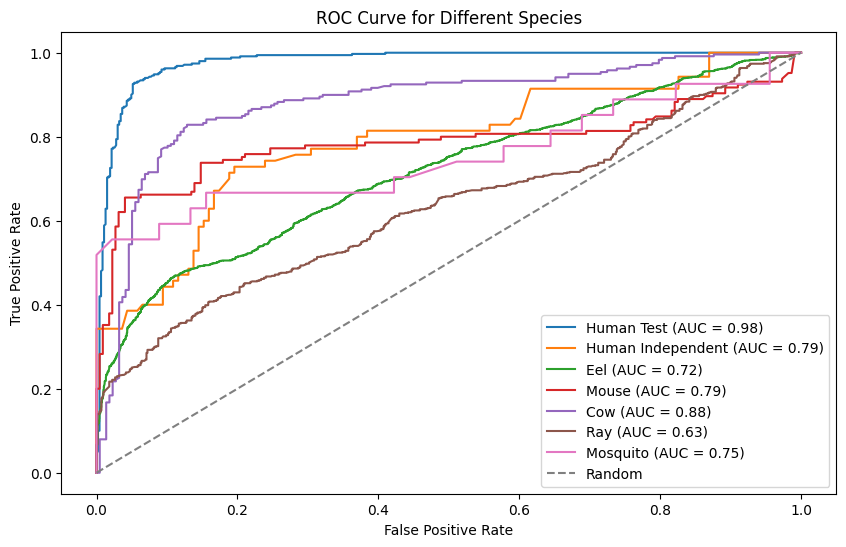

Evaluation for Human Test dataset:
Accuracy: 0.9338
Precision: 0.9134
Recall: 0.9343
F1 Score: 0.9237
MCC: 0.8655
Cohen's Kappa: 0.8653
Predicted Positives: 358.0000
Predicted Negatives: 458.0000


Evaluation for Human Independent dataset:
Accuracy: 0.7356
Precision: 0.6415
Recall: 0.4857
F1 Score: 0.5528
MCC: 0.3774
Cohen's Kappa: 0.3702
Predicted Positives: 53.0000
Predicted Negatives: 155.0000


Evaluation for Eel dataset:
Accuracy: 0.6912
Precision: 0.6153
Recall: 0.5096
F1 Score: 0.5575
MCC: 0.3269
Cohen's Kappa: 0.3235
Predicted Positives: 1726.0000
Predicted Negatives: 3733.0000


Evaluation for Mouse dataset:
Accuracy: 0.7337
Precision: 0.6313
Recall: 0.7793
F1 Score: 0.6975
MCC: 0.4725
Cohen's Kappa: 0.4643
Predicted Positives: 179.0000
Predicted Negatives: 189.0000


Evaluation for Cow dataset:
Accuracy: 0.8206
Precision: 0.8031
Recall: 0.8703
F1 Score: 0.8353
MCC: 0.6414
Cohen's Kappa: 0.6389
Predicted Positives: 259.0000
Predicted Negatives: 198.0000


Evaluation for Ray da

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have a dictionary of datasets
datasets = {
    'Human Test': test_df_,
    'Human Independent': df_humanIndependent,
    'Eel': df_eel,
    'Mouse': df_mouse,
    'Cow': df_cow,
    'Ray': df_ray,
    'Mosquito': df_mosquito
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Initialize a dictionary to store predictions and probabilities for each dataset
prediction_data = {}

# Evaluate and plot ROC curve for each dataset
for species, data in datasets.items():
    X = data.loc[:, 'PubchemFP0':]
    y = data['single-class-label']
    # Get predicted probabilities for each class
    y_probs = best_pipeline.predict_proba(X)

    # Extract probabilities for each class
    y_prob_negative = y_probs[:, 0]  # Probability for the negative class
    y_prob_positive = y_probs[:, 1]  # Probability for the positive class

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Evaluate the model
    y_pred = best_pipeline.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cohen_kappa = cohen_kappa_score(y, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # Include predicted positives and negatives
    predicted_positives = sum(y_pred == 1)
    predicted_negatives = sum(y_pred == 0)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa,
        'Predicted Positives': predicted_positives,
        'Predicted Negatives': predicted_negatives
    }

    # Store the predictions, true labels, and probabilities in a DataFrame
    df_predictions_species = pd.DataFrame({
        'True_Labels': y,
        'Predictions': y_pred,
        'Probabilities_Negative': y_prob_negative,
        'Probabilities_Positive': y_prob_positive
    })

    # Reset the index to start from 0
    df_predictions_species.reset_index(drop=True, inplace=True)

    # Save the DataFrame to an Excel file
    df_predictions_species.to_excel(f'{species}_tpot_predictions_data.xlsx', index_label='Index')

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(cm)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('evaluation_metrics_tpot.xlsx', index_label='Species')


### Cross species evaluation on best model from aggregrate modeling

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix for Human Test dataset:
[[460   6]
 [213 137]]
Confusion Matrix for Human Independent dataset:
[[138   0]
 [ 55  15]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix for Eel dataset:
[[3273  102]
 [1561  523]]
Confusion Matrix for Mouse dataset:
[[222   1]
 [143   2]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix for Cow dataset:
[[213   5]
 [116 123]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix for Ray dataset:
[[657  62]
 [573 114]]
Confusion Matrix for Mosquito dataset:
[[44  1]
 [13 14]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


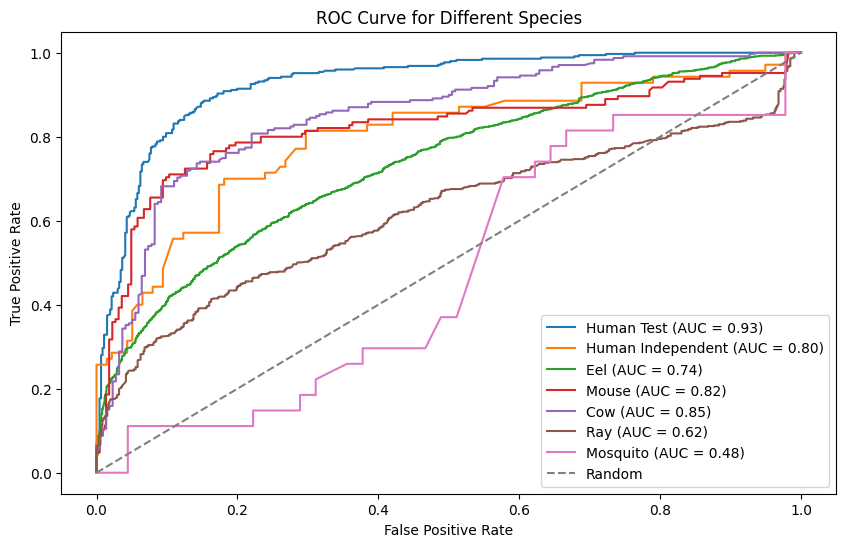

Evaluation for Human Test dataset:
Accuracy: 0.7316
Precision: 0.9580
Recall: 0.3914
F1 Score: 0.5558
MCC: 0.4928
Cohen's Kappa: 0.4086
Predicted Positives: 143.0000
Predicted Negatives: 673.0000


Evaluation for Human Independent dataset:
Accuracy: 0.7356
Precision: 1.0000
Recall: 0.2143
F1 Score: 0.3529
MCC: 0.3914
Cohen's Kappa: 0.2657
Predicted Positives: 15.0000
Predicted Negatives: 193.0000


Evaluation for Eel dataset:
Accuracy: 0.6954
Precision: 0.8368
Recall: 0.2510
F1 Score: 0.3861
MCC: 0.3368
Cohen's Kappa: 0.2549
Predicted Positives: 625.0000
Predicted Negatives: 4834.0000


Evaluation for Mouse dataset:
Accuracy: 0.6087
Precision: 0.6667
Recall: 0.0138
F1 Score: 0.0270
MCC: 0.0506
Cohen's Kappa: 0.0112
Predicted Positives: 3.0000
Predicted Negatives: 365.0000


Evaluation for Cow dataset:
Accuracy: 0.7352
Precision: 0.9609
Recall: 0.5146
F1 Score: 0.6703
MCC: 0.5469
Cohen's Kappa: 0.4809
Predicted Positives: 128.0000
Predicted Negatives: 329.0000


Evaluation for Ray datas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have a dictionary of datasets
datasets = {
    'Human Test': test_df_,
    'Human Independent': df_humanIndependent,
    'Eel': df_eel,
    'Mouse': df_mouse,
    'Cow': df_cow,
    'Ray': df_ray,
    'Mosquito': df_mosquito
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Initialize a dictionary to store predictions and probabilities for each dataset
prediction_data = {}

# Evaluate and plot ROC curve for each dataset
for species, data in datasets.items():

    # feature names
    feature_names = feature1.columns.tolist()

    # Use StandardScaler to scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data.loc[:, 'PubchemFP0':])
    # Update feature names after scaling
    X = pd.DataFrame(X_scaled, columns=feature_names)
    y = data['single-class-label']
    # Get predicted probabilities for each class
    y_probs = best_single_model.predict_proba(X)

    # Extract probabilities for each class
    y_prob_negative = y_probs[:, 0]  # Probability for the negative class
    y_prob_positive = y_probs[:, 1]  # Probability for the positive class

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Evaluate the model
    y_pred = best_pipeline.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cohen_kappa = cohen_kappa_score(y, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # Include predicted positives and negatives
    predicted_positives = sum(y_pred == 1)
    predicted_negatives = sum(y_pred == 0)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa,
        'Predicted Positives': predicted_positives,
        'Predicted Negatives': predicted_negatives
    }

    # Store the predictions, true labels, and probabilities in a DataFrame
    df_predictions_species = pd.DataFrame({
        'True_Labels': y,
        'Predictions': y_pred,
        'Probabilities_Negative': y_prob_negative,
        'Probabilities_Positive': y_prob_positive
    })

    # Reset the index to start from 0
    df_predictions_species.reset_index(drop=True, inplace=True)

    # Save the DataFrame to an Excel file
    df_predictions_species.to_excel(f'{species}_optimized_predictions_data.xlsx', index_label='Index')

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(cm)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('evaluation_metrics_optimized.xlsx', index_label='Species')


In [ ]:
best_single_model

HistGradientBoostingClassifier()

In [ ]:
best_pipeline

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_features=0.35000000000000003,
                                        min_samples_leaf=2,
                                        min_samples_split=16,
                                        random_state=42))])

In [ ]:
joblib.dump(best_pipeline, 'bestPipeline_tpot_pubchem_classification.pkl')


['bestPipeline_tpot_pubchem_classification.pkl']

In [ ]:
joblib.dump(best_single_model, 'bestModel_aggregrate_pubchem_classification.pkl')


['bestModel_aggregrate_pubchem_classification.pkl']

## Conclusion
The RandomForestClassifier with parameters (bootstrap=False, criterion='entropy', max_features=0.35, min_samples_leaf=2, min_samples_split=16, random_state=42) and the HistGradientBoostingClassifier (max_iter=100) were identified as the top models in autoML and aggregate modeling, respectively. Moreover, the best pipeline from TPOT slightly outperformed the best model in aggregate modeling across various datasets.

## Referenes
*  PubChem Substructure Fingerprint. (2009). PubChem; V1.3. ftp://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.pdf
*  https://colab.research.google.com/drive/1Kunjr8hF3MQPPN_AGedBP07AOE5Bcu1M?usp=sharing#scrollTo=1msUAjuKiIGP
*   Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283